In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import os
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm, trange
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from efficientnet_pytorch import EfficientNet


In [3]:
seed = 42
torch.cuda.get_device_name()

'GeForce RTX 2070'

In [4]:
labels = pd.read_csv("./input/training-labels.csv")

In [5]:
labels.groupby(['Drscore']).size()

Drscore
0    9846
1    1027
2    2300
3     648
4     324
dtype: int64

In [6]:
labels_small = labels.sample(frac=0.1, random_state=seed)

In [7]:
labels_small.groupby(['Drscore']).size()

Drscore
0    998
1     83
2    242
3     56
4     35
dtype: int64

In [8]:
train_df, val_df = train_test_split(labels, test_size=0.2,stratify=labels['Drscore'], random_state = seed)

In [33]:
BATCH_SIZE = 2**2
NUM_WORKERS = 1
LEARNING_RATE = 5e-5
NUM_EPOCHS = 20
LOG_FREQ = 200
TIME_LIMIT = 8 * 60 * 60
torch.cuda.empty_cache()

In [10]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.Resize(400),
            transforms.CenterCrop(400)
        ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2), shear=15,
                                            resample=Image.BILINEAR)
                ])
            ])

        transforms_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Filename'].values[index]

        directory = './input/Test' if self.mode == 'test' else './input/output_combined2'
        sample = Image.open(f'./{directory}/{filename}')

        assert sample.mode == 'RGB'

        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def __len__(self):
        return self.df.shape[0]


In [31]:
def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor):
    ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
    assert len(predicts.shape) == 1
    assert len(confs.shape) == 1
    assert len(targets.shape) == 1
    assert predicts.shape == confs.shape and confs.shape == targets.shape

    confs = confs.cpu().numpy()
    predicts = predicts.cpu().numpy()
    targets = targets.cpu().numpy()

    res = accuracy_score(targets, predicts)
    return res

In [12]:
class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val, n = 1) :
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [13]:
subsetclass_df = train_df[train_df['Drscore']!=0]

In [14]:
class_sample_count = np.unique(train_df['Drscore'], return_counts=True)[1]
weight = 1. / class_sample_count
samples_weight = weight[train_df['Drscore']]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [15]:
class_sample_count_normalised = np.max(class_sample_count)/class_sample_count

In [16]:
train_dataset = ImageDataset(train_df, mode='train')
val_dataset = ImageDataset(val_df, mode='val')
subsetclass_dataset = ImageDataset(subsetclass_df, mode='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

subsetclass_loader = DataLoader(subsetclass_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                             shuffle=False)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
def train(train_loader, model, criterion, optimizer, epoch, logging = True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avg_score = AverageMeter()

    model.train()
    num_steps = len(train_loader)

    end = time.time()
    lr_str = ''

    for i, (input_, target) in enumerate(train_loader):
        if i >= num_steps:
            break

        output = model(input_.to(device))
        loss = criterion(output, target.to(device))

        confs, predicts = torch.max(output.detach(), dim=1)
        avg_score.update(GAP(predicts, confs, target))

        losses.update(loss.data.item(), input_.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if logging and i % LOG_FREQ == 0:
            print(f'{epoch} [{i}/{num_steps}]\t'
                        f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                        f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
                        f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
                        + lr_str)
        if has_time_run_out():
            break

    print(f' * average GAP on train {avg_score.avg:.4f}')
    return avg_score.avg

In [19]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets = [], [], []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.to(device))
            output = activation(output)

            confs, predicts = torch.topk(output, 1)
            all_confs.append(confs)
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, confs, targets

In [20]:
def test(test_loader, model):
    predicts, confs, targets = inference(test_loader, model)
    predicts = predicts.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    return cohen_kappa_score(targets, predicts)

In [21]:
def train_loop(epochs, train_loader, test_loader, model, criterion, optimizer, 
               validate=True):
    train_res = []

    test_res = []
    for epoch in trange(1, epochs + 1):
        start_time = time.time()
        train_acc = train(train_loader, model, criterion, optimizer, epoch, logging=True)
        if has_time_run_out():
            break
        train_res.append(train_acc)

        if validate:
            test_acc = test(test_loader, model)
            test_res.append(test_acc)
            print(f"validation score: {test_acc}")
            
    return train_res, test_res

In [ ]:
def generate_submission(test_loader, model, label_encoder: Any):
    sample_sub = pd.read_csv('../input/landmark-recognition-2019/recognition_sample_submission.csv')

    predicts_gpu, confs_gpu, _ = inference(test_loader, model)
    predicts, confs = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy()

    labels = [label_encoder.inverse_transform(pred) for pred in predicts]
    print('labels')
    print(np.array(labels))
    print('confs')
    print(np.array(confs))

    sub = test_loader.dataset.df
    def concat(label: np.ndarray, conf: np.ndarray) -> str:
        return ' '.join([f'{L} {c}' for L, c in zip(label, conf)])
    sub['landmarks'] = [concat(label, conf) for label, conf in zip(labels, confs)]

    sample_sub = sample_sub.set_index('id')
    sub = sub.set_index('id')
    sample_sub.update(sub)

    sample_sub.to_csv('submission.csv')

In [22]:
def has_time_run_out() -> bool:
    return time.time() - global_start_time > TIME_LIMIT - 2000

In [23]:
# model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
# model.fc = nn.Linear(model.fc.in_features, 5)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)

Loaded pretrained weights for efficientnet-b4


In [75]:
model.load_state_dict(torch.load("./model/efficientnet_os.ptm"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [24]:
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_sample_count_normalised).float().cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [38]:
global_start_time = time.time()

In [39]:
train_res, test_res = train_loop(NUM_EPOCHS, train_loader, val_loader, model, criterion, optimizer)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

1 [0/2829]	time 1.180 (1.180)	loss 0.5254 (0.5254)	GAP 1.0000 (1.0000)
1 [200/2829]	time 1.026 (0.907)	loss 0.8659 (0.8838)	GAP 0.5000 (0.7512)
1 [400/2829]	time 1.044 (0.900)	loss 0.5438 (0.8957)	GAP 1.0000 (0.7338)
1 [600/2829]	time 0.952 (0.902)	loss 2.1051 (0.9127)	GAP 0.0000 (0.7342)
1 [800/2829]	time 0.904 (0.899)	loss 0.6801 (0.8770)	GAP 1.0000 (0.7456)
1 [1000/2829]	time 0.821 (0.893)	loss 1.0331 (0.8694)	GAP 0.7500 (0.7485)
1 [1200/2829]	time 0.837 (0.893)	loss 0.1378 (0.8557)	GAP 1.0000 (0.7546)
1 [1400/2829]	time 0.942 (0.892)	loss 0.1404 (0.8413)	GAP 1.0000 (0.7568)
1 [1600/2829]	time 1.060 (0.890)	loss 0.9646 (0.8423)	GAP 0.7500 (0.7525)
1 [1800/2829]	time 0.795 (0.887)	loss 0.4742 (0.8382)	GAP 1.0000 (0.7525)
1 [2000/2829]	time 0.771 (0.886)	loss 0.6214 (0.8337)	GAP 0.7500 (0.7544)
1 [2200/2829]	time 0.839 (0.887)	loss 0.3125 (0.8452)	GAP 1.0000 (0.7547)
1 [2400/2829]	time 0.804 (0.887)	loss 0.4470 (0.8457)	GAP 0.7500 (0.7554)
1 [2600/2829]	time 0.931 (0.886)	loss 0.7499 


  5%|███▉                                                                          | 1/20 [49:00<15:31:03, 2940.18s/it]

2 [0/2829]	time 1.097 (1.097)	loss 0.4430 (0.4430)	GAP 1.0000 (1.0000)
2 [200/2829]	time 1.044 (0.883)	loss 0.9515 (0.7978)	GAP 0.7500 (0.7575)
2 [400/2829]	time 0.915 (0.873)	loss 0.9818 (0.8362)	GAP 0.7500 (0.7556)
2 [600/2829]	time 0.898 (0.874)	loss 0.5256 (0.8213)	GAP 0.5000 (0.7558)
2 [800/2829]	time 0.886 (0.873)	loss 1.1308 (0.7797)	GAP 0.7500 (0.7697)
2 [1000/2829]	time 0.862 (0.873)	loss 0.3163 (0.7706)	GAP 1.0000 (0.7735)
2 [1200/2829]	time 0.843 (0.877)	loss 0.1663 (0.7621)	GAP 1.0000 (0.7766)
2 [1400/2829]	time 0.886 (0.878)	loss 0.1387 (0.7525)	GAP 1.0000 (0.7794)
2 [1600/2829]	time 1.085 (0.876)	loss 0.5548 (0.7556)	GAP 1.0000 (0.7772)
2 [1800/2829]	time 0.885 (0.876)	loss 0.7974 (0.7543)	GAP 0.7500 (0.7761)
2 [2000/2829]	time 0.756 (0.877)	loss 0.4018 (0.7517)	GAP 0.7500 (0.7771)
2 [2200/2829]	time 0.814 (0.878)	loss 0.4088 (0.7587)	GAP 1.0000 (0.7775)
2 [2400/2829]	time 0.819 (0.878)	loss 0.4561 (0.7594)	GAP 0.7500 (0.7770)
2 [2600/2829]	time 1.075 (0.879)	loss 1.1692 


 10%|███████▌                                                                    | 2/20 [1:37:34<14:39:43, 2932.39s/it]

3 [0/2829]	time 1.013 (1.013)	loss 0.7089 (0.7089)	GAP 0.7500 (0.7500)
3 [200/2829]	time 0.990 (0.880)	loss 0.4929 (0.7063)	GAP 0.5000 (0.7512)
3 [400/2829]	time 0.942 (0.877)	loss 0.7982 (0.7349)	GAP 0.7500 (0.7618)
3 [600/2829]	time 0.935 (0.887)	loss 1.0816 (0.7270)	GAP 0.5000 (0.7650)
3 [800/2829]	time 0.930 (0.892)	loss 0.5866 (0.7132)	GAP 1.0000 (0.7681)
3 [1000/2829]	time 0.882 (0.890)	loss 0.2847 (0.7024)	GAP 1.0000 (0.7722)
3 [1200/2829]	time 0.850 (0.889)	loss 0.4612 (0.6891)	GAP 0.7500 (0.7771)
3 [1400/2829]	time 0.961 (0.888)	loss 0.1462 (0.6778)	GAP 0.7500 (0.7810)
3 [1600/2829]	time 1.135 (0.888)	loss 0.1778 (0.6745)	GAP 1.0000 (0.7811)
3 [1800/2829]	time 0.858 (0.888)	loss 0.2585 (0.6681)	GAP 1.0000 (0.7814)
3 [2000/2829]	time 0.776 (0.889)	loss 0.3592 (0.6599)	GAP 1.0000 (0.7855)
3 [2200/2829]	time 0.795 (0.889)	loss 0.2164 (0.6637)	GAP 1.0000 (0.7857)
3 [2400/2829]	time 0.910 (0.888)	loss 0.1651 (0.6650)	GAP 1.0000 (0.7857)
3 [2600/2829]	time 0.993 (0.889)	loss 0.6749 


 15%|███████████▍                                                                | 3/20 [2:26:39<13:51:55, 2936.21s/it]

4 [0/2829]	time 1.064 (1.064)	loss 0.3591 (0.3591)	GAP 1.0000 (1.0000)
4 [200/2829]	time 1.015 (0.900)	loss 0.3881 (0.6426)	GAP 0.5000 (0.7575)
4 [400/2829]	time 0.969 (0.897)	loss 0.7093 (0.6585)	GAP 0.7500 (0.7556)
4 [600/2829]	time 0.886 (0.902)	loss 0.7117 (0.6449)	GAP 0.2500 (0.7583)
4 [800/2829]	time 0.895 (0.901)	loss 0.3611 (0.6098)	GAP 1.0000 (0.7750)
4 [1000/2829]	time 0.808 (0.894)	loss 0.6177 (0.6125)	GAP 0.7500 (0.7772)
4 [1200/2829]	time 0.907 (0.893)	loss 0.0470 (0.6163)	GAP 1.0000 (0.7835)
4 [1400/2829]	time 0.873 (0.896)	loss 0.1107 (0.6053)	GAP 1.0000 (0.7882)
4 [1600/2829]	time 1.083 (0.895)	loss 0.6788 (0.6056)	GAP 0.7500 (0.7875)
4 [1800/2829]	time 0.821 (0.893)	loss 0.6554 (0.5992)	GAP 0.5000 (0.7886)
4 [2000/2829]	time 0.772 (0.891)	loss 0.1789 (0.5953)	GAP 1.0000 (0.7922)
4 [2200/2829]	time 0.816 (0.891)	loss 0.3260 (0.5971)	GAP 1.0000 (0.7945)
4 [2400/2829]	time 0.829 (0.892)	loss 0.1948 (0.5959)	GAP 1.0000 (0.7939)
4 [2600/2829]	time 1.010 (0.892)	loss 0.7580 


 20%|███████████████▏                                                            | 4/20 [3:15:50<13:04:10, 2940.64s/it]

5 [0/2829]	time 1.115 (1.115)	loss 0.9353 (0.9353)	GAP 0.7500 (0.7500)
5 [200/2829]	time 1.017 (0.941)	loss 0.3854 (0.5802)	GAP 0.7500 (0.7823)
5 [400/2829]	time 0.938 (0.920)	loss 0.3586 (0.6003)	GAP 0.7500 (0.7812)
5 [600/2829]	time 0.881 (0.911)	loss 0.7087 (0.6030)	GAP 0.2500 (0.7770)
5 [800/2829]	time 0.915 (0.903)	loss 0.1160 (0.5634)	GAP 1.0000 (0.7934)
5 [1000/2829]	time 0.843 (0.900)	loss 0.2467 (0.5473)	GAP 1.0000 (0.7980)
5 [1200/2829]	time 0.835 (0.901)	loss 0.0777 (0.5332)	GAP 1.0000 (0.8064)
5 [1400/2829]	time 0.941 (0.900)	loss 0.0952 (0.5332)	GAP 1.0000 (0.8087)
5 [1600/2829]	time 1.059 (0.898)	loss 0.7376 (0.5284)	GAP 0.7500 (0.8101)
5 [1800/2829]	time 0.786 (0.895)	loss 0.1592 (0.5317)	GAP 1.0000 (0.8127)
5 [2000/2829]	time 0.795 (0.895)	loss 0.2289 (0.5285)	GAP 0.7500 (0.8146)
5 [2200/2829]	time 0.821 (0.897)	loss 0.1567 (0.5253)	GAP 1.0000 (0.8146)
5 [2400/2829]	time 0.822 (0.897)	loss 0.3790 (0.5226)	GAP 0.7500 (0.8165)
5 [2600/2829]	time 1.121 (0.897)	loss 0.5762 


 25%|███████████████████                                                         | 5/20 [4:05:16<12:17:02, 2948.17s/it]

6 [0/2829]	time 1.040 (1.040)	loss 0.3724 (0.3724)	GAP 1.0000 (1.0000)
6 [200/2829]	time 1.001 (0.884)	loss 0.1791 (0.5009)	GAP 0.7500 (0.7935)
6 [400/2829]	time 0.972 (0.885)	loss 1.0502 (0.5190)	GAP 0.5000 (0.7943)
6 [600/2829]	time 0.892 (0.890)	loss 0.2850 (0.5047)	GAP 0.7500 (0.8037)
6 [800/2829]	time 0.907 (0.891)	loss 0.2136 (0.4801)	GAP 1.0000 (0.8180)
6 [1000/2829]	time 0.837 (0.888)	loss 0.4095 (0.4804)	GAP 1.0000 (0.8217)
6 [1200/2829]	time 0.828 (0.889)	loss 0.1142 (0.4739)	GAP 1.0000 (0.8274)
6 [1400/2829]	time 0.885 (0.887)	loss 0.0937 (0.4725)	GAP 1.0000 (0.8291)
6 [1600/2829]	time 1.060 (0.887)	loss 0.1126 (0.4751)	GAP 1.0000 (0.8282)
6 [1800/2829]	time 0.810 (0.887)	loss 0.3164 (0.4661)	GAP 0.7500 (0.8329)
6 [2000/2829]	time 0.762 (0.888)	loss 0.2604 (0.4594)	GAP 1.0000 (0.8352)
6 [2200/2829]	time 0.833 (0.890)	loss 0.7246 (0.4622)	GAP 0.7500 (0.8331)
6 [2400/2829]	time 0.898 (0.889)	loss 0.3169 (0.4638)	GAP 1.0000 (0.8337)
6 [2600/2829]	time 1.048 (0.889)	loss 0.5124 


 30%|██████████████████████▊                                                     | 6/20 [4:54:25<11:27:59, 2948.52s/it]

7 [0/2829]	time 1.013 (1.013)	loss 0.9734 (0.9734)	GAP 0.7500 (0.7500)
7 [200/2829]	time 0.962 (0.887)	loss 0.2201 (0.4573)	GAP 0.7500 (0.7985)
7 [400/2829]	time 0.957 (0.890)	loss 0.7432 (0.4432)	GAP 0.5000 (0.8080)
7 [600/2829]	time 0.913 (0.896)	loss 0.2023 (0.4452)	GAP 0.7500 (0.8128)
7 [800/2829]	time 0.889 (0.895)	loss 0.1994 (0.4291)	GAP 1.0000 (0.8252)
7 [1000/2829]	time 0.817 (0.891)	loss 0.1277 (0.4145)	GAP 1.0000 (0.8337)
7 [1200/2829]	time 0.868 (0.889)	loss 0.1517 (0.4069)	GAP 0.7500 (0.8399)
7 [1400/2829]	time 0.945 (0.890)	loss 0.1019 (0.4096)	GAP 1.0000 (0.8387)
7 [1600/2829]	time 1.162 (0.892)	loss 0.3331 (0.4065)	GAP 1.0000 (0.8392)
7 [1800/2829]	time 0.806 (0.892)	loss 0.3983 (0.4089)	GAP 0.7500 (0.8411)
7 [2000/2829]	time 0.754 (0.891)	loss 0.1063 (0.4041)	GAP 1.0000 (0.8436)
7 [2200/2829]	time 0.868 (0.891)	loss 0.1911 (0.4041)	GAP 1.0000 (0.8450)
7 [2400/2829]	time 0.835 (0.890)	loss 0.4586 (0.4010)	GAP 0.7500 (0.8452)
7 [2600/2829]	time 0.995 (0.892)	loss 0.4219 


 35%|██████████████████████████▌                                                 | 7/20 [5:43:33<10:38:49, 2948.41s/it]

8 [0/2829]	time 1.075 (1.075)	loss 0.5156 (0.5156)	GAP 0.7500 (0.7500)
8 [200/2829]	time 1.003 (0.897)	loss 0.1284 (0.4355)	GAP 0.7500 (0.7985)
8 [400/2829]	time 1.025 (0.897)	loss 0.4168 (0.4462)	GAP 0.7500 (0.8092)
8 [600/2829]	time 0.911 (0.900)	loss 0.2825 (0.4441)	GAP 0.7500 (0.8199)
8 [800/2829]	time 0.911 (0.894)	loss 0.1797 (0.4086)	GAP 1.0000 (0.8368)
8 [1000/2829]	time 0.849 (0.888)	loss 0.1047 (0.4035)	GAP 1.0000 (0.8419)
8 [1200/2829]	time 0.858 (0.890)	loss 0.0486 (0.3997)	GAP 1.0000 (0.8439)
8 [1400/2829]	time 0.959 (0.892)	loss 0.1174 (0.3955)	GAP 0.5000 (0.8469)
8 [1600/2829]	time 1.066 (0.892)	loss 0.1179 (0.3859)	GAP 1.0000 (0.8502)
8 [1800/2829]	time 0.820 (0.890)	loss 0.4919 (0.3854)	GAP 0.7500 (0.8498)
8 [2000/2829]	time 0.774 (0.889)	loss 0.8696 (0.3801)	GAP 0.5000 (0.8531)
8 [2200/2829]	time 0.838 (0.891)	loss 0.3502 (0.3761)	GAP 1.0000 (0.8544)
8 [2400/2829]	time 0.821 (0.892)	loss 0.0628 (0.3707)	GAP 1.0000 (0.8534)
8 [2600/2829]	time 0.994 (0.892)	loss 0.3072 


 40%|██████████████████████████████▊                                              | 8/20 [6:32:48<9:50:02, 2950.23s/it]

9 [0/2829]	time 1.137 (1.137)	loss 0.1332 (0.1332)	GAP 1.0000 (1.0000)
9 [200/2829]	time 0.984 (0.897)	loss 0.0545 (0.3516)	GAP 1.0000 (0.8470)
9 [400/2829]	time 0.977 (0.892)	loss 0.4023 (0.3581)	GAP 0.7500 (0.8479)
9 [600/2829]	time 0.885 (0.889)	loss 0.1770 (0.3553)	GAP 0.7500 (0.8465)
9 [800/2829]	time 0.896 (0.888)	loss 0.0575 (0.3410)	GAP 1.0000 (0.8555)
9 [1000/2829]	time 0.837 (0.888)	loss 0.1108 (0.3415)	GAP 0.7500 (0.8571)
9 [1200/2829]	time 0.873 (0.889)	loss 0.0700 (0.3371)	GAP 1.0000 (0.8593)
9 [1400/2829]	time 0.899 (0.890)	loss 0.0948 (0.3335)	GAP 0.7500 (0.8624)
9 [1600/2829]	time 1.031 (0.886)	loss 0.0960 (0.3327)	GAP 1.0000 (0.8640)
9 [1800/2829]	time 0.817 (0.884)	loss 0.6015 (0.3309)	GAP 0.7500 (0.8649)
9 [2000/2829]	time 0.873 (0.886)	loss 0.0713 (0.3280)	GAP 1.0000 (0.8669)
9 [2200/2829]	time 0.855 (0.887)	loss 0.1924 (0.3288)	GAP 1.0000 (0.8680)
9 [2400/2829]	time 0.924 (0.887)	loss 0.0184 (0.3309)	GAP 1.0000 (0.8675)
9 [2600/2829]	time 0.979 (0.886)	loss 0.0989 


 45%|██████████████████████████████████▋                                          | 9/20 [7:21:53<9:00:36, 2948.79s/it]

10 [0/2829]	time 1.069 (1.069)	loss 0.1317 (0.1317)	GAP 1.0000 (1.0000)
10 [200/2829]	time 1.001 (0.892)	loss 0.3282 (0.3325)	GAP 0.7500 (0.8619)
 * average GAP on train 0.8469


In [40]:
torch.save(model.state_dict(), "./model/efficientnet_wc.ptm")

In [41]:
df_c = pd.DataFrame({'train':train_res, 'val':test_res})

In [42]:
df = pd.read_csv("./model/efficientnet_wc_log.csv")
df = pd.concat([df,df_c])

In [43]:
df.to_csv("./model/efficientnet_wc_log.csv", index=False)

In [44]:
df

,train,val
0,NaN,0.416814
1,NaN,0.440677
2,NaN,0.368532
0,0.749912,0.431359
1,0.770414,0.349037
2,0.780311,0.402755
3,0.788264,0.384918
4,0.809120,0.365920
5,0.829975,0.434385
6,0.840049,0.393594


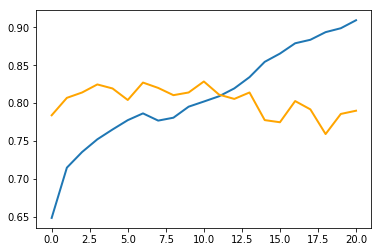

In [58]:
plt.plot(range(df.shape[0]), df['train'], lw=2)
plt.plot(range(df.shape[0]),  df['val'], color='orange', lw=2)

In [27]:
predicts, confs, targets = inference(val_loader, model)

In [28]:
print(classification_report(targets.cpu(), predicts.cpu()))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1969
           1       0.20      0.12      0.15       205
           2       0.64      0.47      0.54       460
           3       0.56      0.61      0.58       130
           4       0.66      0.57      0.61        65

   micro avg       0.78      0.78      0.78      2829
   macro avg       0.58      0.54      0.56      2829
weighted avg       0.75      0.78      0.76      2829



In [29]:
confusion_matrix(targets.cpu(), predicts.cpu())

array([[1852,   61,   49,    4,    3],
       [ 152,   25,   25,    3,    0],
       [ 153,   35,  216,   50,    6],
       [   6,    3,   32,   79,   10],
       [   9,    0,   14,    5,   37]], dtype=int64)

In [30]:
cohen_kappa_score(targets.cpu(), predicts.cpu())

0.5023637989084222

In [60]:
cohen_kappa_score(targets.cpu(), predicts.cpu())

0.4769054675621083